In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from typing import List
import sklearn as sk

# DATA DOWNLOADING AND PROCESSING

In [2]:
GetFacebookInformation = yf.Ticker("META")

print(GetFacebookInformation.info)


{'address1': '1 Meta Way', 'city': 'Menlo Park', 'state': 'CA', 'zip': '94025', 'country': 'United States', 'phone': '650 543 4800', 'website': 'https://investor.fb.com', 'industry': 'Internet Content & Information', 'industryKey': 'internet-content-information', 'industryDisp': 'Internet Content & Information', 'sector': 'Communication Services', 'sectorKey': 'communication-services', 'sectorDisp': 'Communication Services', 'longBusinessSummary': 'Meta Platforms, Inc. engages in the development of products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and wearables worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment offers Facebook, which enables people to share, discuss, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a m

In [4]:
# Let us  get historical stock prices for Facebook 
data =  GetFacebookInformation.history(period="5y")
vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
vectors.pop()
for vector in vectors:
    vector.append(1)
vectors

[[181.34758608864288,
  184.11465454101562,
  184.51423974210056,
  181.2576851343801,
  1],
 [183.30551158106815,
  181.9969024658203,
  184.364385666914,
  181.15779642525757,
  1],
 [182.88595790471106,
  182.81602478027344,
  183.28552785327426,
  180.69827661617887,
  1],
 [180.0889254550035,
  177.2819061279297,
  180.3486444015163,
  176.972237126383,
  1],
 [174.81451948895557,
  163.97601318359375,
  174.86446954304714,
  160.83934184361087,
  1],
 [163.5364877794758,
  167.3224639892578,
  168.10163603499254,
  160.66951937480036,
  1],
 [167.30248912366054,
  167.99176025390625,
  168.54118037530623,
  164.4555188915972,
  1],
 [168.1216290844608,
  168.15159606933594,
  169.52013918735648,
  167.05275581519155,
  1],
 [169.98963753269808,
  173.16627502441406,
  173.68571290950652,
  168.66104535069456,
  1],
 [174.564786723475,
  174.6347198486328,
  177.67149111978915,
  173.61579665390218,
  1],
 [178.29082650070768,
  177.91123962402344,
  179.78923666516846,
  176.6026

In [5]:
y_vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
y_values = [sum(y_vector) / 4 for y_vector in y_vectors]
y_values.pop(0)
len(y_values)

1258

In [6]:
# Split data into train and test sets
split_index = int(0.8 * len(vectors))
train_vectors, test_vectors = vectors[:split_index], vectors[split_index:]
train_y_values, test_y_values = y_values[:split_index], y_values[split_index:]

# BASIC FUNCTIONS FOR ALGEBRA CALCULATION

In [7]:
from typing import List # define vector
Vector = List[float]

In [8]:
def dot(v, w) -> float: #define scalar product
    return sum(v_i * w_i for v_i, w_i in zip(v, w))


In [9]:
def predict(x: Vector, beta: Vector) -> float: # prediction function
    return dot(x,beta)

In [10]:

def vector_sum(vectors: List[Vector]) -> Vector:    
    assert vectors, "No vectors provided!"
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    return [sum(vector[i] for vector in vectors) for i in range(num_elements)]
    

In [11]:
def scalar_multiply(c: float, v:Vector) ->Vector: 
    return [c *v_i for v_i in v]

In [12]:
def vector_mean(vectors: List[Vector]) -> Vector: 
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

# FUNCTION FOR CALCULATING GRADIENT DESCENT

In [13]:
def error(x: Vector, y:float, beta: Vector) ->float:  #error calculating function
    return predict(x,beta) -y

In [14]:
def squared_error(x:Vector, y: float, beta: Vector) -> float: # square of error calculating function
    return error(x,y,beta) **2

In [15]:
def sqerror_gradient(x: Vector, y: float, beta:Vector) -> Vector:
    err = error(x,y,beta)
    return [2*err*x_i for x_i in x]

In [16]:
from typing import List, Callable
# gradient step calculating

In [17]:
def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    return [v_i - step_size * gradient_i for v_i, gradient_i in zip(v, gradient)]


In [18]:
def least_squares_fit(xs: List[Vector], ys: List[float], learning_rate: float = 0.00000001, num_steps: int = 10000, batch_size: int = 1) -> Vector:
    guess = [0.0] * len(xs[0])
    for _ in range(num_steps):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start + batch_size]
            batch_ys = ys[start:start + batch_size]
            gradient = vector_mean([sqerror_gradient(x, y, guess) for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, learning_rate)
    return guess



In [19]:
learning_rate = 0.00000001
beta = least_squares_fit(train_vectors, train_y_values, learning_rate, 10000, 1)
print("Nghiệm tìm được bằng least_squares_fit:", beta)

Nghiệm tìm được bằng least_squares_fit: [-0.16227623397363605, 0.6474340442425802, 0.2265612086584472, 0.2880827486593303, 0.026818474668094755]


In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
new_vectors = train_vectors
for vector in new_vectors:
    vector.pop()
model.fit(new_vectors, train_y_values)
coef = model.coef_.tolist()
coef.append(model.intercept_)
print("Hệ số của các biến:", coef)


Hệ số của các biến: [-0.2637895586855289, 0.6942013127858819, 0.18579046742487632, 0.3822672267115382, 1.0073020257203495]


# Đây là sử dụng model của sklearn để predict

In [21]:
test = data[['Open', 'Close', 'High', 'Low']].values.tolist()
last_day_data = test[-1]
last_day_data.append(1)
y = predict(last_day_data, beta)
print("Giá cổ phiếu dự đoán ngày tiếp theo (bằng least square fit): ", y)


Giá cổ phiếu dự đoán ngày tiếp theo (bằng least square fit):  476.8074957050787


# Evaluation Matrix

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
# Predictions using custom least squares fit
train_predictions_custom = [predict(x, beta) for x in train_vectors]
test_predictions_custom = [predict(x, beta) for x in test_vectors]

In [24]:
# Train and predict with sklearn's LinearRegression
model = LinearRegression()
model.fit(train_vectors, train_y_values)
for test in test_vectors:
    test.pop()
train_predictions_sklearn = model.predict(new_vectors)
test_predictions_sklearn = model.predict(test_vectors)

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

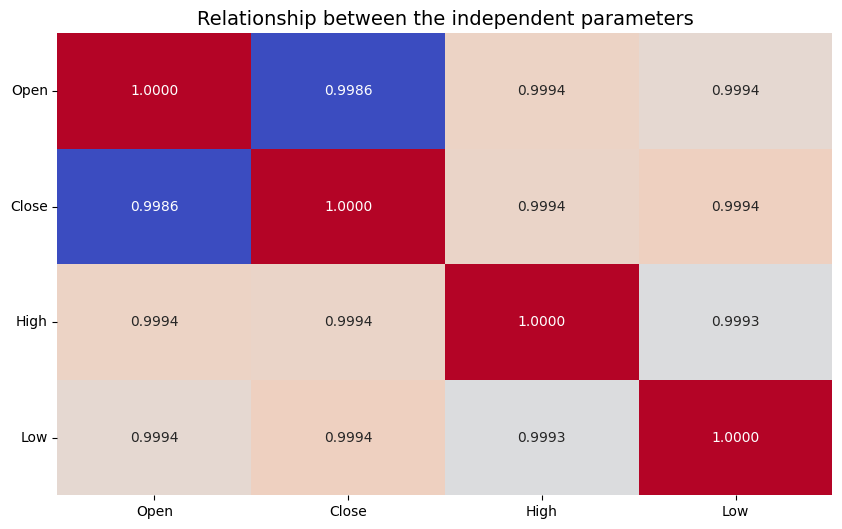

In [26]:
# Tạo bảng tương quan
corr_matrix = data[['Open', 'Close', 'High', 'Low']].corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', ax=ax, cbar=False, annot_kws={"size": 10})

# Định dạng bảng
ax.set_title('Relationship between the independent parameters', fontsize=14)
ax.set_xticklabels(corr_matrix.columns, rotation=0, fontsize=10)
ax.set_yticklabels(corr_matrix.columns, rotation=0, fontsize=10)

# Hiển thị bảng
plt.show()

In [27]:
# Lưu bảng dưới dạng hình ảnh
fig.savefig('relationship_table.png', dpi=300, bbox_inches='tight')

In [29]:

# Calculating evaluation metrics
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

metrics = {
    "Model": [],
    "R-Squared": [],
    "Adjusted R-Squared": [],
    "Multiple R": [],
    "Standard Error": [],
    "MSE": []
}

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), len(train_vectors[0]))
    mse = mean_squared_error(y_true, y_pred)
    std_error = np.sqrt(mse)
    metrics["Model"].append(model_name)
    metrics["R-Squared"].append(r2)
    metrics["Adjusted R-Squared"].append(adj_r2)
    metrics["Multiple R"].append(np.sqrt(r2))
    metrics["Standard Error"].append(std_error)
    metrics["MSE"].append(mse)

evaluate_model(test_y_values, test_predictions_custom, "Custom Least Squares")
evaluate_model(test_y_values, test_predictions_sklearn, "Sklearn LinearRegression")

# Display evaluation metrics
evaluation_df = pd.DataFrame(metrics)
print(evaluation_df)

# Save the model
import pickle

with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('custom_least_squares_model.pkl', 'wb') as file:
    pickle.dump(beta, file)


                      Model  R-Squared  Adjusted R-Squared  Multiple R  \
0      Custom Least Squares   0.991310            0.991169    0.995645   
1  Sklearn LinearRegression   0.991403            0.991264    0.995692   

   Standard Error        MSE  
0        7.738666  59.886951  
1        7.697023  59.244156  


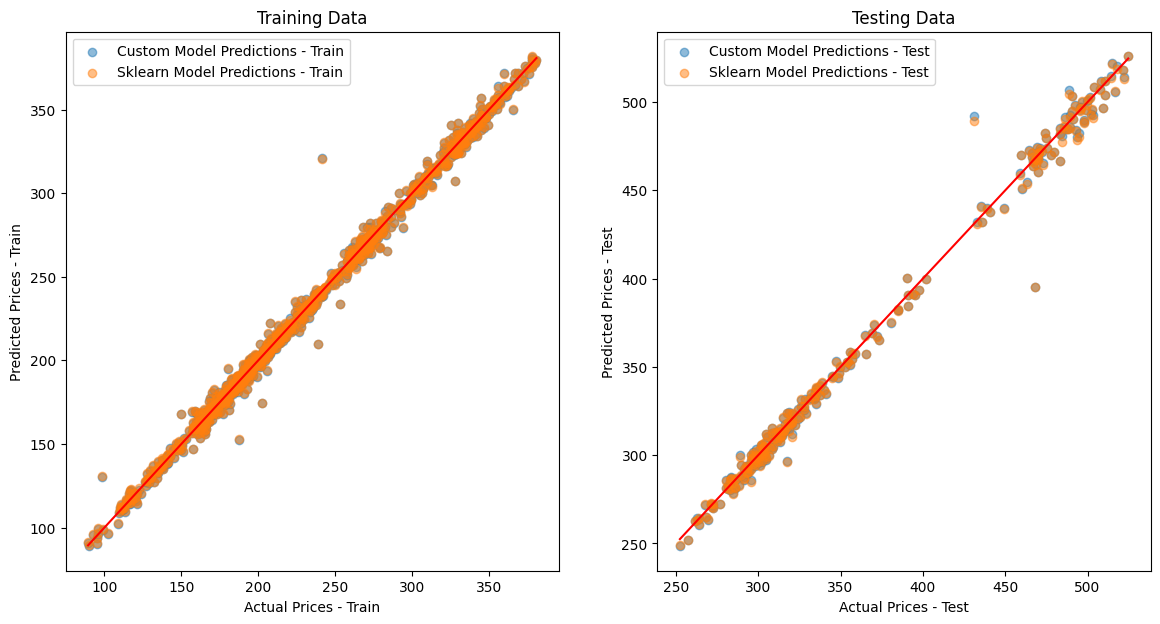

In [31]:
# Vẽ biểu đồ scatter plot
plt.figure(figsize=(14, 7))

# Biểu đồ scatter plot cho tập train
plt.subplot(1, 2, 1)
plt.scatter(train_y_values, train_predictions_custom, label="Custom Model Predictions - Train", alpha=0.5)
plt.scatter(train_y_values, train_predictions_sklearn, label="Sklearn Model Predictions - Train", alpha=0.5)
plt.plot([min(train_y_values), max(train_y_values)], [min(train_y_values), max(train_y_values)], color='red')
plt.xlabel('Actual Prices - Train')
plt.ylabel('Predicted Prices - Train')
plt.title('Training Data')
plt.legend()

# Biểu đồ scatter plot cho tập test
plt.subplot(1, 2, 2)
plt.scatter(test_y_values, test_predictions_custom, label="Custom Model Predictions - Test", alpha=0.5)
plt.scatter(test_y_values, test_predictions_sklearn, label="Sklearn Model Predictions - Test", alpha=0.5)
plt.plot([min(test_y_values), max(test_y_values)], [min(test_y_values), max(test_y_values)], color='red')
plt.xlabel('Actual Prices - Test')
plt.ylabel('Predicted Prices - Test')
plt.title('Testing Data')
plt.legend()

plt.show()
